In [12]:
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
sp500 = yf.Ticker("^GSPC")

In [21]:
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

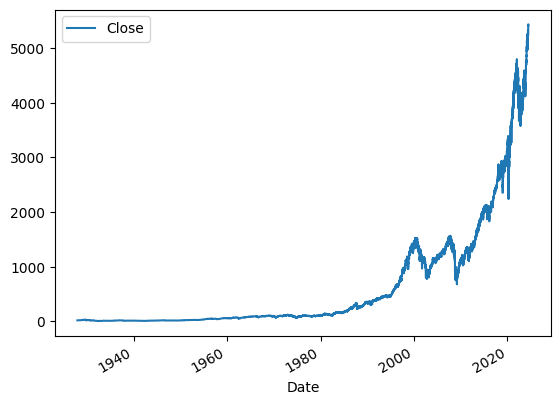

In [22]:
sp500.plot.line(y="Close", use_index = True)

In [23]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [24]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [25]:
sp500 = sp500.loc["1990-01-01":].copy()


In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100,random_state=1)
train = sp500.iloc[:100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [27]:
from sklearn.metrics import precision_score 

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [28]:
precision_score(test["Target"], preds)

0.55

<Axes: xlabel='Date'>

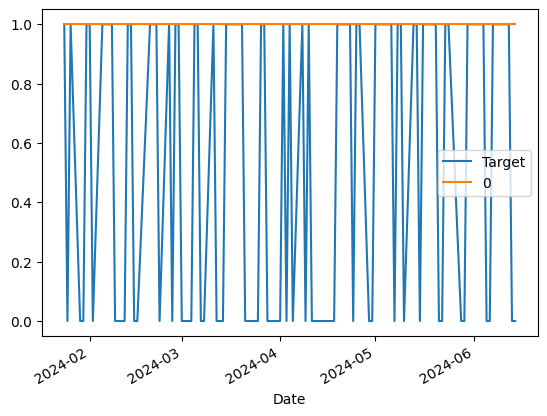

In [29]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [30]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [31]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [32]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

Predictions
0    3578
1    2602
Name: count, dtype: int64

In [33]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5292083013066872

In [54]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534951
0    0.465049
Name: count, dtype: float64

In [55]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = (f"Close_Ratio_{horizon}")
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend = f"Trend_{horizon}"
    sp500["Trend"] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend]
    

/var/folders/cr/2v0p62js4yg161nws06lqptw0000gn/T/ipykernel_25313/2176454767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
/var/folders/cr/2v0p62js4yg161nws06lqptw0000gn/T/ipykernel_25313/2176454767.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["Trend"] = sp500.shift(1).rolling(horizon).sum()["Target"]


In [59]:
sp500 = sp500.dropna

In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [62]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1 
    preds [preds < .6] = 0 
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [67]:
predictions = backtest(sp500, model, new_predictors)


AttributeError: 'function' object has no attribute 'shape'

In [68]:
predictions["Predictions"].value_counts()

Predictions
0    3578
1    2602
Name: count, dtype: int64

In [69]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5292083013066872